# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# План проекта:
1. Загрузим и изучим данные. 
2. Проанализируем данные, подготовим их к обучению моделей.
3. Подготовим выборки для обучения моделей.
4. Обучим разные модели: линейную регрессию, SGDClassifier, библиотеку градиентного бустинга CatBoost.
5. Для каждой модели попробуем разные гиперпараметры.
6. Проанализируем качество моделей.
7. Выберем лучшую модель.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt

import spacy

from numpy.random import RandomState
state = np.random.RandomState(12345)

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression, SGDClassifier
from catboost import CatBoostClassifier

from sklearn.feature_extraction.text import CountVectorizer 

# from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer 

from sklearn.dummy import DummyClassifier

from tqdm import notebook
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', 1000)

In [2]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
toxic_comments = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
toxic_comments.head()

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [5]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


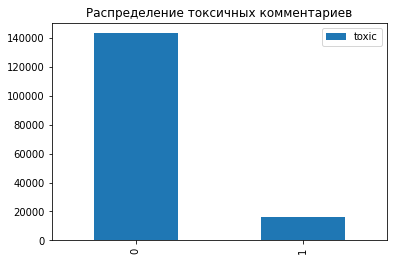

In [6]:
toxic_comments['toxic'].value_counts().plot(kind='bar')
plt.legend()
plt.title('Распределение токсичных комментариев')
plt.show()

In [7]:
print(f"Процент объектов класса 1 к общему объёму датасета: {(sum(toxic_comments['toxic']) / len(toxic_comments) * 100):.0f}%")

Процент объектов класса 1 к общему объёму датасета: 10%


Изначально в данных существенный дисбаланс классов. Учтем это в дальнейшем.

Очистим наши данные:\
Удалим все нерелевантные символы (например, любые символы, не относящиеся к цифро-буквенным).\
Переведем все символы в нижний регистр.\
Токенизируем текст, разделив его на индивидуальные слова.\
Проведем лемматизацию.

In [8]:
# lemmatizer = WordNetLemmatizer()
def standardize_text(text):
    text = re.sub(r'[^a-zA-z ]', ' ', text)
    text = text.lower()
    token = nltk.word_tokenize(text)
    text = [word for word in token if word not in stop_words]
#     text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text

In [9]:
tqdm.pandas()

toxic_comments['standardize_text'] = toxic_comments['text'].progress_apply(standardize_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [10]:
# Проведем лемматизацию
nlp = spacy.load('en_core_web_sm')

def lemmatize(text):
    doc = nlp(text)
    return ' '.join([word.lemma_ for word in doc])

In [11]:
tqdm.pandas()

toxic_comments['standardize_text'] = toxic_comments['standardize_text'].progress_apply(lemmatize)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [12]:
toxic_comments.head()

,Unnamed: 0,text,toxic,standardize_text
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation edit make username hardcore metallica fan revert vandalism closure gas vote new york doll fac please remove template talk page since retire
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,aww match background colour seemingly stick thank talk january utc
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man really try edit war guy constantly remove relevant information talk edit instead talk page seem care format actual info
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,make real suggestion improvement wonder section statistic later subsection type accident think reference may need tidy exact format ie date format etc later one else first preference format style reference want please let know appear backlog article review guess may delay reviewer turn list relevant form eg wikipedia good_article_nomination transport
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0,sir hero chance remember page


In [13]:
# Разделим текст на тренировочную и тестовую выборки

X = toxic_comments['standardize_text']
y = toxic_comments['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=state)

In [14]:
count_vectorizer = CountVectorizer(stop_words=stop_words)

X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

Вывод по этапу 1.
Данные очищены, подготовлены для обучения моделей.

## Обучение

### Логистическая регрессия

In [15]:
%%time

param_grid = {'C' : [0.1, 1.0, 10.0], 'penalty' : ['l1', 'l2']}
            
clf = GridSearchCV(LogisticRegression(random_state=state, class_weight='balanced'), 
                   param_grid, 
                   scoring='f1',
                   verbose=True,
                   cv=5, 
                   n_jobs = -1)
clf.fit(X_train_counts, y_train)
clf_best_score = clf.best_score_
clf_best_params = clf.best_params_
# predictions_clf = clf.predict(X_test_counts)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 4min 43s, sys: 9min 12s, total: 13min 55s
Wall time: 13min 56s


In [16]:
# f1_clf = f1_score(y_test, predictions_clf)
# print("f1 логистической регрессии = %.3f" % (f1_clf))

### Модель SGDClassifier

In [17]:
%%time
model_sgd = SGDClassifier(random_state=state, class_weight='balanced')
hyperparams = [{'loss':['hinge', 'log', 'modified_huber'],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5]}]

model_sgd = GridSearchCV(model_sgd, 
                         hyperparams, 
                         scoring='f1', 
                         cv=5, 
                         n_jobs = -1)
model_sgd.fit(X_train_counts, y_train)
# predictions_sgd = model_sgd.predict(X_test_counts)
model_sgd.fit(X_train_counts, y_train)
model_sgd_best_score = model_sgd.best_score_
model_sgd_best_params = model_sgd.best_params_

CPU times: user 32min 49s, sys: 1min 28s, total: 34min 18s
Wall time: 34min 19s


In [18]:
# f1_sgd = f1_score(y_test, predictions_sgd)
# print("f1 SGDClassifier = %.3f" % (f1_sgd))

### Модель CatBoostClassifier

In [19]:
%%time


model_cbc = CatBoostClassifier()

parameters_cbc = {'iterations': [10],
        'learning_rate': [0.03, 0.1],
        'depth': [6, 8],
              }
model_cbc = GridSearchCV(model_cbc, 
                        parameters_cbc, 
                        cv=5, 
                         scoring='f1',
                        verbose=False,
                        n_jobs=-1).fit(X_train_counts, y_train)
model_cbc_best_score = model_cbc.best_score_
model_cbc_best_params = model_sgd.best_params_
# predictions_cbc = model_cbc.predict(X_test_counts)

0:	learn: 0.6625291	total: 1.26s	remaining: 11.4s
1:	learn: 0.6335477	total: 2.39s	remaining: 9.57s
2:	learn: 0.6055700	total: 3.62s	remaining: 8.44s
3:	learn: 0.5790274	total: 5.08s	remaining: 7.63s
4:	learn: 0.5558776	total: 6.31s	remaining: 6.31s
5:	learn: 0.5341097	total: 7.51s	remaining: 5s
6:	learn: 0.5127512	total: 8.77s	remaining: 3.76s
7:	learn: 0.4934942	total: 10s	remaining: 2.51s
8:	learn: 0.4753940	total: 11.2s	remaining: 1.25s
9:	learn: 0.4589874	total: 12.4s	remaining: 0us
0:	learn: 0.6617616	total: 1.75s	remaining: 15.8s
1:	learn: 0.6326570	total: 2.94s	remaining: 11.8s
2:	learn: 0.6057378	total: 4.15s	remaining: 9.69s
3:	learn: 0.5801161	total: 5.34s	remaining: 8.01s
4:	learn: 0.5560953	total: 6.52s	remaining: 6.52s
5:	learn: 0.5348210	total: 7.74s	remaining: 5.16s
6:	learn: 0.5141173	total: 8.97s	remaining: 3.84s
7:	learn: 0.4948486	total: 10.2s	remaining: 2.54s
8:	learn: 0.4761676	total: 11.4s	remaining: 1.27s
9:	learn: 0.4591507	total: 12.8s	remaining: 0us
0:	learn:

In [20]:
# f1_cbc = f1_score(y_test, predictions_cbc)
# print("f1 CatBoostClassifier = %.3f" % (f1_cbc))

In [21]:
index = ['LogisticRegression',
         'SGDClassifier',
         'CatBoostClassifier']
data = {'F1_score':[clf_best_score, 
              model_sgd_best_score, 
              model_cbc_best_score]}
        

data_analys = pd.DataFrame(data=data, index=index)
data_analys['Достижение целевого показателя'] = data_analys['F1_score'] > 0.75
data_analys.style.highlight_max(color="yellow")

,F1_score,Достижение целевого показателя
LogisticRegression,0.760441,True
SGDClassifier,0.757399,True
CatBoostClassifier,0.497551,False


По результатам проверки лучшей моделью признаем модель LogisticRegression. SGDClassifier отстает совсем ненамного, целевой показатель также выполняет. 

In [25]:
f1_lr_final = f1_score(y_test, clf.best_estimator_.predict(X_test_counts))
print('F1 score на тестовой выборке лучшей модели', f1_lr_final)

F1 score на тестовой выборке лучшей модели 0.7584097859327217


In [26]:
# Проверим модель на адекватность
dummy = DummyClassifier( strategy='uniform').fit(X_train_counts, y_train)
dummy_pred = dummy.predict(X_test_counts)
f1_dumme = f1_score(y_test, dummy_pred)
print("f1 DummyClassifier = %.3f" % (f1_dumme))

f1 DummyClassifier = 0.164


## Выводы

### Общий вывод по проекту.
Загрузили, изучили и подготовили данные к исследованию. \
Подготовили данные для обучения моделей с учетом требований моделей.\
Обучили разные модели: 'LinearRegression', 'SGDRegressor', 'CatBoostRegressor'\
Для каждой модели попробовали разные гиперпараметры.\
Занесли данные в таблицу, визуализировали результаты.\
Выбрали лучшую модель. В данном задании лучшие результаты показывают простые линейные модели.\
Тестовое задание лучшая модель выполнила.\
Проверили модель на адекватность.
